# What this is
I am using data science tools in order to analyze my financial decisions. Below I will be:
* Looking at data correlation;
* Cleaning the data to avoid empty and redundant information;
* Using LinearRegression and PolinomiaRegression to "predict" my average spending using index as parameter (not expecting good results, but as illustration for the next point);
* Using AutoRegression, commonly used for time series, and then also implementing it using LinearRegression for p = 1 (for illustrative purposes);

# Goals

Using my financial information, I want to:
* Understand my pattern of spending;
* Understand why I spent so little in general in the past, enough to be proud of my responsability with money, but now its been the opposite (this will be further demonstrated below);
* Make a personal analysis tool for myself that can help me avoid lifestyle creep;

# Reading Finances File

In [37]:
import pandas as pd
import plotly.figure_factory as ff
import numpy as np

In [38]:


file_path = "finances_fake_data.xlsx"

# Load the "historic" sheet into a DataFrame
historic_df = pd.read_excel(file_path, sheet_name='historic')
# Remove completely empty rows and columns
historic_cleaned_df = historic_df.dropna(how='all').dropna(axis=1, how='all')

# Display the first few rows of the "historic" sheet to understand its structure
historic_cleaned_df.head()


,mes,Renda,Trabalhos,Pessoas,Gastos,Investimento Adicionado,aluguel,roommates,Agua Mensal,Rancho Indiv.,Rancho,custo especial,Lazer Mensal,comida,Uber,extras,beleza
0,2024-07-01,4000,2,1,?,?,620,1,73.20,88.11,588.11,?,80.45,40.00,50,40,0
1,2024-08-01,4000,2,1,?,?,620,1,80.00,108.43,608.43,?,90.50,44.49,60,190,0
2,2024-09-01,4000,2,1,?,?,620,1,25.80,91.70,591.70,?,133.90,60.50,190,90,30
3,2024-10-01,4000,2,1,?,?,620,1,47.81,52.00,552.00,?,161.27,72.00,220,70,101
4,2024-11-01,4000,2,1,?,?,620,1,44.45,159.82,659.82,?,116.00,120.00,200,75,0


In [39]:
# checking it loaded all months, by looking at water consumption column
historic_cleaned_df["Agua Mensal"]

,Agua Mensal
0,73.20
1,80.00
2,25.80
3,47.81
4,44.45


In [40]:

# Function to convert all object columns to float where possible
def convert_objects_to_float(df):
    for col in df.columns:
        if df[col].dtype == 'object':  # Check if the column is of type object
            try:
                # Attempt to convert the object column to float
                df[col] = pd.to_numeric(df[col], errors='ignore')
            except ValueError:
                # If conversion fails, leave the column as is
                pass
    return df

# Apply the conversion function to your DataFrame
historic_cleaned_df = convert_objects_to_float(historic_cleaned_df)

# Display the updated DataFrame with converted columns
print(historic_cleaned_df.dtypes)


mes                        datetime64[ns]
Renda                               int64
Trabalhos                           int64
Pessoas                             int64
Gastos                             object
Investimento Adicionado            object
aluguel                             int64
roommates                           int64
Agua Mensal                       float64
Rancho Indiv.                     float64
Rancho                            float64
custo especial                     object
Lazer Mensal                      float64
comida                            float64
Uber                                int64
extras                              int64
beleza                              int64
dtype: object


<ipython-input-40-515e76153663>:7: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



In [41]:

historic_only_numerics = historic_cleaned_df.select_dtypes(include=['number'])
historic_only_numerics.head()

,Renda,Trabalhos,Pessoas,aluguel,roommates,Agua Mensal,Rancho Indiv.,Rancho,Lazer Mensal,comida,Uber,extras,beleza
0,4000,2,1,620,1,73.20,88.11,588.11,80.45,40.00,50,40,0
1,4000,2,1,620,1,80.00,108.43,608.43,90.50,44.49,60,190,0
2,4000,2,1,620,1,25.80,91.70,591.70,133.90,60.50,190,90,30
3,4000,2,1,620,1,47.81,52.00,552.00,161.27,72.00,220,70,101
4,4000,2,1,620,1,44.45,159.82,659.82,116.00,120.00,200,75,0


# Relevant Correlation


In [42]:

historic_useful_for_correlation = historic_only_numerics.drop([
      "Lazer Marginal", # Derived
      "Uber marginal", # Derived
      "Lazer Proporcional a Renda", # Derived
      "festive events", # Too little sample
      "Rancho Indiv.", # Derived
      "roommates", # Doesnt change
      "aluguel", # irrelevant
      "Trabalhos",
      "Pessoas",
      "Renda" # the only moment it changes is when rent changes
  ], axis=1,errors='ignore')
historic_useful_for_correlation = historic_useful_for_correlation.dropna(how="any")
historic_useful_for_correlation

,Agua Mensal,Rancho,Lazer Mensal,comida,Uber,extras,beleza
0,73.20,588.11,80.45,40.00,50,40,0
1,80.00,608.43,90.50,44.49,60,190,0
2,25.80,591.70,133.90,60.50,190,90,30
3,47.81,552.00,161.27,72.00,220,70,101
4,44.45,659.82,116.00,120.00,200,75,0


In [43]:

corr = historic_useful_for_correlation.corr()
x = list(corr.columns)
y = list(corr.index)
z = np.array(corr)

fig = ff.create_annotated_heatmap(
    z,
    x = x,
    y = y ,
    annotation_text = np.around(z, decimals=2),
    hoverinfo='z',
    colorscale='Viridis'
    )
fig.show()



In [44]:
variables_with_no_interesting_correlation = []
for column in corr.columns:
  correlations_for_column = []
  for row in corr.columns:
    if abs(corr[column][row]) > 0.5 and column != row:
      correlations_for_column.append(corr[column][row])
  if len(correlations_for_column) == 0:
    variables_with_no_interesting_correlation.append(column)

print("variables_with_no_interesting_correlation", variables_with_no_interesting_correlation)

variables_with_no_interesting_correlation ['extras']


Just because these variables didnt have any interesting correlation, doesnt mean they are not useful. On the contrary, too much correlation might cause redundancy, and considering these low correlation variables can allow for complex behaviour not previously thought of

# Controllable Variables

In here, I will be looking at the behaviour, through the months, of the costs that I have conscious and immediate control over.

To count as controllable variables, it must be:
* "Optional": assumes that I could be reducing or cutting them;
* "Consumable/Integrative": The overall result of the cost is a combination of several concious uses over the period of a month. I can spend as much as I so choose, and there is hardly a cap to how much that value is. Their only restriction is my willingness to spend money that month.

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

controllable_variables = [
    "Lazer Mensal",
    "comida",
    "Uber",
    "beleza"
]



In [46]:
historic_controllable = historic_useful_for_correlation[controllable_variables]
corr = historic_controllable.corr()
x = list(corr.columns)
y = list(corr.index)
z = np.array(corr)

fig = ff.create_annotated_heatmap(
    z,
    x = x,
    y = y ,
    annotation_text = np.around(z, decimals=2),
    hoverinfo='z',
    colorscale='Viridis'
    )
fig.show()



average_controllable_spendings 354.022


[170.45, 194.98999999999998, 414.4, 554.27, 436.0]

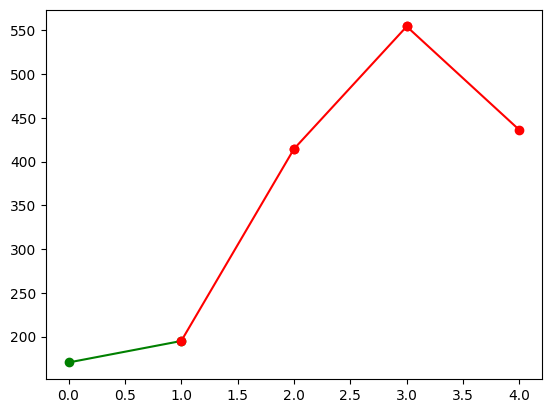

In [47]:
average_controllable_spendings = 0

for variable in controllable_variables:
  average_controllable_spendings += historic_useful_for_correlation[variable].mean()

print("average_controllable_spendings", average_controllable_spendings)

all_controllable_spendings_of_a_month = []
month_spending_color = []
for row in historic_useful_for_correlation.index:
  row_controllable_spendings = 0
  for variable in controllable_variables:
    row_controllable_spendings += historic_useful_for_correlation[variable][row]

  if row_controllable_spendings > average_controllable_spendings:
    color = "red"
  else:
    color = "green"
  if row_controllable_spendings == 0:
    continue
  month_spending_color.append(color)
  all_controllable_spendings_of_a_month.append(row_controllable_spendings)


# Plot the line using segments of different colors
fig, ax = plt.subplots()

for i in range(1, len(all_controllable_spendings_of_a_month)):
    ax.plot([i-1, i],
            [all_controllable_spendings_of_a_month[i-1], all_controllable_spendings_of_a_month[i]],
            marker='o',
            color=month_spending_color[i])
all_controllable_spendings_of_a_month

Reference Material For Regression: https://medium.com/@shuv.sdr/polynomial-regression-in-python-58198fb0973f

Reference Material for Time Series: https://www.timescale.com/blog/how-to-work-with-time-series-in-python/

I will be passing a single input for the regression, that will be the index of the data in the list. This has an implicit expectation that the data is "self explanatory", in the sense that its behaviour has some consistent linear relatonship with time. In a sense, what is defining the result of the regression are the values themselves.
This is somewhat similar to predicting stock! At least, considering the inputs. When predicting stocks, we have some expectation that the data has a self-correlation, a correlation with previous values.

Below the linear regression, I have used a time series model for the same purpose to compare results: AutoRegression.
And then, finally, I made the same model but manually using LinearRegression for p = 1, to demonstrate how it works.

It will, of course, not be highly efficient at prediction. Or at least, it is not expected to. After all, we dont actually believe there to be a pattern of self-correlation (but it might be interesting to check if there is, comparing results with the future "better model" that we will use).


In [81]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

twod_all_controllable_spendings_of_a_month = []
X = np.array([])
y = np.array([])
for i, value in enumerate(all_controllable_spendings_of_a_month):
  X = np.append(X,i)
  y = np.append(y,value)
  twod_all_controllable_spendings_of_a_month.append([i, value])

lr = LinearRegression()
lr.fit(X.reshape(-1, 1), y)


pr = PolynomialFeatures(degree = 3)
X_poly = pr.fit_transform(np.array(X).reshape(-1, 1))
lr_2 = LinearRegression()
lr_2.fit(X_poly, y)

LinearRegression()

prediction lr: 621.136


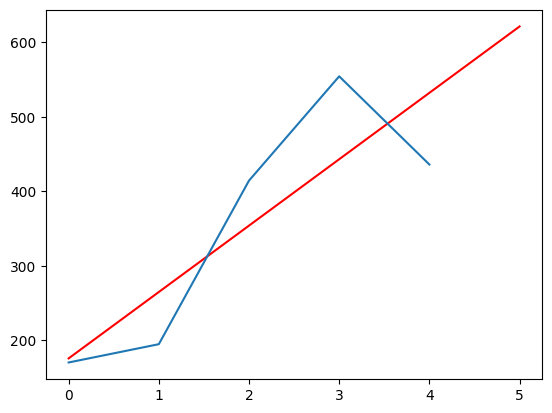

In [82]:

range_of_prediction =  [i for i in range(len(all_controllable_spendings_of_a_month) +1)]
reshaped_range = np.array(range_of_prediction).reshape(-1, 1)
y_pred_lr = lr.predict(reshaped_range)
# y_pred_pr = lr_2.predict(pr.fit_transform(reshaped_range))

sns.lineplot(x = [i for i in range(len(y_pred_lr))], y = y_pred_lr,
             color="red")

#sns.lineplot(x = [i for i in range(len(y_pred_pr))], y = y_pred_pr,color="yellow")
sns.lineplot(x = [i for i in range(len(all_controllable_spendings_of_a_month))], y = all_controllable_spendings_of_a_month)

print("prediction lr:",y_pred_lr[-1])

In [83]:
data = pd.DataFrame(all_controllable_spendings_of_a_month, columns=['y'])
#data['x'] = data.index
data

,y
0,170.45
1,194.99
2,414.40
3,554.27
4,436.00


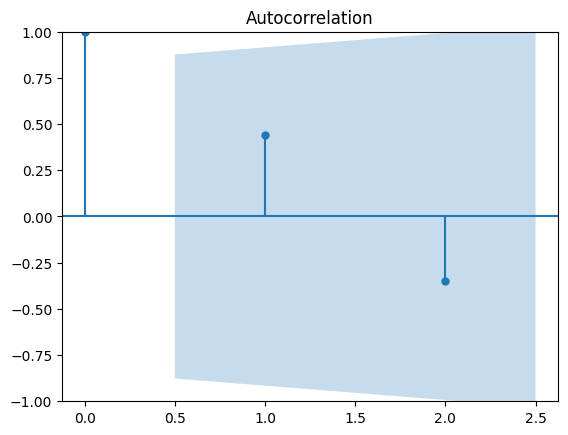

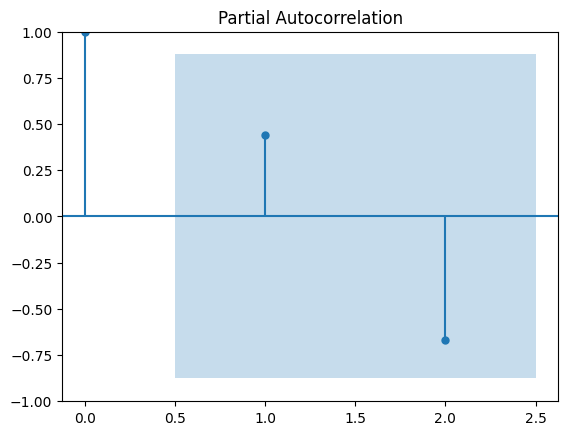

In [84]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'data' is the time series data
plot_acf(data)
plot_pacf(data)
plt.show()

In [85]:
from statsmodels.tsa.ar_model import AutoReg

n = 0
# AR
model = AutoReg(all_controllable_spendings_of_a_month, lags=[1])
ar_model = model.fit()
predictions = ar_model.predict(start=1, end=len(all_controllable_spendings_of_a_month)+n)  # Replace n with the number of future values to predict
predictions

array([316.22471158, 328.81847637, 441.41822914, 513.19858291,
       452.50320549])

<Axes: >

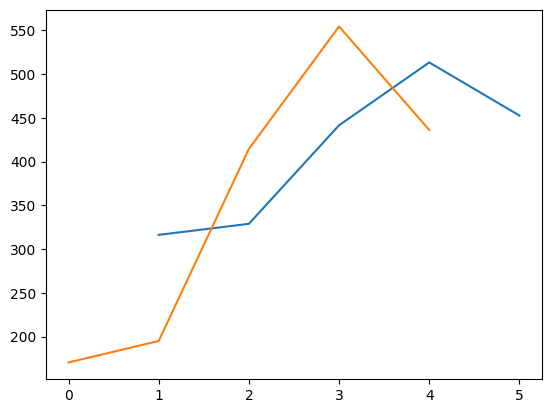

In [86]:

sns.lineplot(x = [i+1 for i in range(len(predictions))], y = predictions)
sns.lineplot(x = [i for i in range(len(all_controllable_spendings_of_a_month))], y = all_controllable_spendings_of_a_month)

In [79]:

# representando auto regression com linear regression, para p=1
ar_lr = LinearRegression()

y_x = y[:-1]
y_y = y[1:]
ar_lr.fit(np.array(y_x).reshape(-1, 1), y_y)


reshaped_range = np.array([y[-1]]).reshape(-1, 1)
y_pred_auto_lr = ar_lr.predict(reshaped_range)

y_pred_auto_lr

array([452.50320549])

But it makes us ponder, what then are the variables we should consider?